# 🧠 LGG Brain Tumor Segmentation with UNet

## Model Overview
- **Architecture:** UNet
- **Encoder:** ResNet34 (pretrained on ImageNet for training)
- **Input channels:** 1 (grayscale MRI)
- **Output channels/classes:** 1 (binary tumor mask)
- **Loss functions:** Dice Loss + Binary Cross-Entropy Loss
- **Optimizer:** Adam (lr=1e-4)
- **Device:** GPU (if available)

## Dataset Overview
- **Source folders:** `kaggle_3m`, `lgg-mri-segmentation/kaggle_3m`
- **Total .tif files:** 15716
- **Patients (folders):** 220
- **Original slices:**
  - Tumor: 2746
  - Non-tumor: 5112

## Data Balancing
- Balanced the dataset using class weights in the loss function:
  - Tumor weight: 0.6505
  - Non-tumor weight: 0.3495

## Data Splits
- **Training:** 80%
- **Validation:** 10%
- **Test:** 10%
- **Batch size:** 32
- **Transforms:** 
  - Train: Resize + flips + shift/scale/rotate
  - Validation/Test: Resize only

## Training
- **Epochs:** 40
- **Live plotting of training & validation loss**
- **Final train loss:** 0.1058 
- **Final val loss:** 0.1140
- **Final test loss:** 0.1115

## Visualization
- Random examples of:
  - MRI slices
  - Ground truth masks
  - Model predictions
- Also visualized augmented tumor slices


In [1]:
import os
import glob
from pathlib import Path
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

# === USING LOCAL DATA FOLDERS ===
candidates = [
    Path("data/kaggle_3m"),
    Path("data/lgg-mri-segmentation") / "kaggle_3m",
]
existing = [p for p in candidates if p.exists()]
if not existing:
    print("No local data folders found. Checked:", [str(p) for p in candidates])
else:
    print("Using data folders:", [str(p) for p in existing])

# === Collect image–mask pairs from all existing data folders ===
all_tif = []
for root in existing:
    all_tif.extend(glob.glob(str(root / "**/*.tif"), recursive=True))
all_tif = sorted(all_tif)
mask_files = [f for f in all_tif if f.endswith("_mask.tif")]
image_files = [f for f in all_tif if not f.endswith("_mask.tif")]

print("Total .tif files:", len(all_tif))
print("Images:", len(image_files))
print("Masks:", len(mask_files))

pairs = []
for img_path in image_files:
    img_path = Path(img_path)
    mask_path = img_path.with_name(img_path.stem + "_mask.tif")
    if mask_path.exists():
        pairs.append((str(img_path), str(mask_path)))

print("Valid pairs:", len(pairs))

df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])

Using data folders: ['data\\kaggle_3m', 'data\\lgg-mri-segmentation\\kaggle_3m']
Total .tif files: 15716
Images: 7858
Masks: 7858
Valid pairs: 7858


Slices with tumor    : 2746
Slices without tumor : 5112


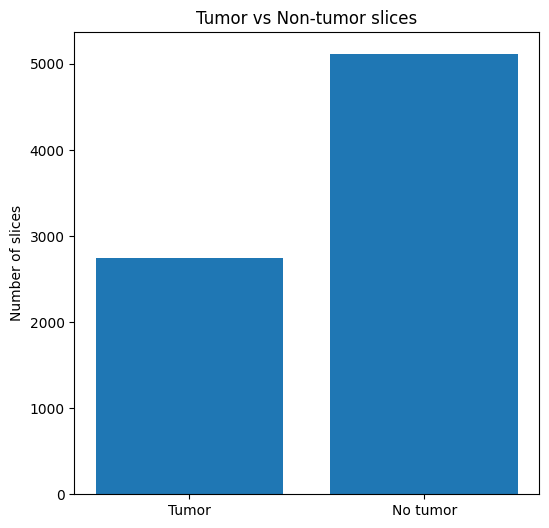

In [2]:
def has_tumor(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return int(mask.max() > 0)

df["tumor"] = df["mask_path"].apply(has_tumor)

tumor_counts = df["tumor"].value_counts().sort_index()
n_non_tumor = tumor_counts.get(0, 0)
n_tumor = tumor_counts.get(1, 0)

print(f"Slices with tumor    : {n_tumor}")
print(f"Slices without tumor : {n_non_tumor}")

plt.figure()
plt.bar(["Tumor", "No tumor"], [n_tumor, n_non_tumor])
plt.title("Tumor vs Non-tumor slices")
plt.ylabel("Number of slices")
plt.show()


In [3]:


# Compute class weights (inverse frequency)
num_tumor = df["tumor"].sum()
num_non_tumor = len(df) - num_tumor

weight_tumor = num_non_tumor / (num_tumor + num_non_tumor)
weight_non_tumor = num_tumor / (num_tumor + num_non_tumor)

print(f"Tumor weight: {weight_tumor:.4f}, Non-tumor weight: {weight_non_tumor:.4f}")

# Assign weight to each sample
df["weight"] = df["tumor"].apply(lambda x: weight_tumor if x == 1 else weight_non_tumor)

Tumor weight: 0.6505, Non-tumor weight: 0.3495


In [4]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_total = len(df)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:n_train+n_val]
test_df  = df.iloc[n_train+n_val:]

print(f"Training slices: {len(train_df)}, Validation slices: {len(val_df)}, Test slices: {len(test_df)}")

Training slices: 6286, Validation slices: 785, Test slices: 787


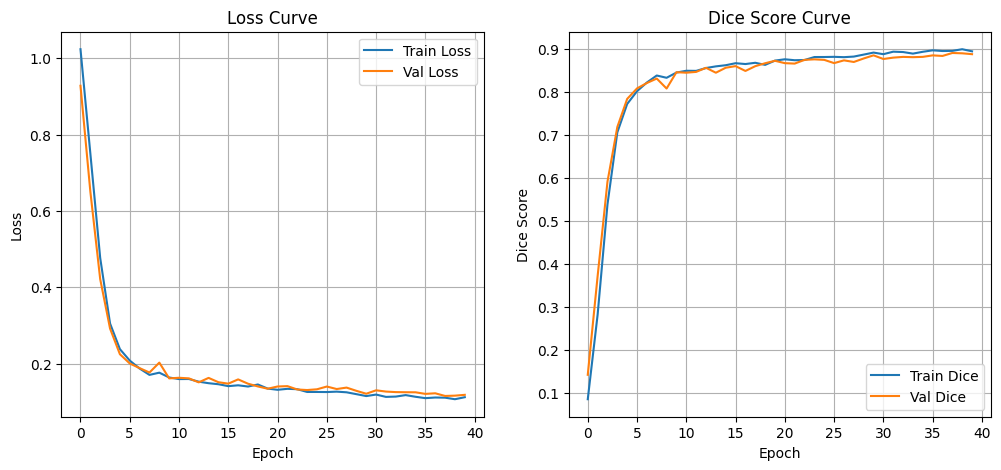


FINAL TEST LOSS: 0.1141
Model saved!


In [8]:
# %% [markdown]
# # LGG Brain Tumor Segmentation - UNet (Live Plot + Dice Score)

# %%
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
import cv2
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------
# Dataset
# --------------------
class LGGDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE) / 255.0
        mask = (cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE) > 0).astype(np.float32)

        if "weight" in row:
            weight = row["weight"]
        else:
            weight = 1.0  # default weight if not using weights

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        img = torch.tensor(img).unsqueeze(0).float()
        mask = torch.tensor(mask).unsqueeze(0).float()
        weight = torch.tensor(weight).float()

        return img, mask, weight

# --------------------
# Transforms
# --------------------
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
])
val_transform = A.Compose([A.Resize(128, 128)])
test_transform = A.Compose([A.Resize(128, 128)])

# --------------------
# Loaders
# --------------------
train_loader = DataLoader(LGGDataset(train_df, transform=train_transform), batch_size=32, shuffle=True)
val_loader   = DataLoader(LGGDataset(val_df, transform=val_transform), batch_size=32, shuffle=False)
test_loader  = DataLoader(LGGDataset(test_df, transform=test_transform), batch_size=32, shuffle=False)

# --------------------
# Model
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

# --------------------
# Loss & Optimizer
# --------------------
bce_loss_fn = nn.BCEWithLogitsLoss(reduction='none')  # use per-sample weight
dice_loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 40

# --------------------
# Training loop with live plotting
# --------------------
train_losses, val_losses = [], []
train_dices, val_dices = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---- TRAIN ----
    model.train()
    train_loss, train_dice_epoch = 0.0, 0.0
    for imgs, masks, weights in tqdm(train_loader, desc="Training", leave=False):
        imgs, masks, weights = imgs.to(device), masks.to(device), weights.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        bce = bce_loss_fn(outputs, masks)
        weighted_bce = (bce * weights.view(-1,1,1,1)).mean()
        dice = dice_loss_fn(outputs, masks)
        loss = weighted_bce + dice

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice_epoch += (1 - dice.item())

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice_epoch / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_dice_epoch = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks, weights in tqdm(val_loader, desc="Validating", leave=False):
            imgs, masks, weights = imgs.to(device), masks.to(device), weights.to(device)
            outputs = model(imgs)

            bce = bce_loss_fn(outputs, masks)
            weighted_bce = (bce * weights.view(-1,1,1,1)).mean()
            dice = dice_loss_fn(outputs, masks)
            loss = weighted_bce + dice

            val_loss += loss.item()
            val_dice_epoch += (1 - dice.item())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice_epoch / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)

    # ---- Print metrics ----
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}")

    # ---- Live plotting ----
    clear_output(wait=True)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(train_dices, label="Train Dice")
    plt.plot(val_dices, label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title("Dice Score Curve")
    plt.legend()
    plt.grid()

    plt.show()

# --------------------
# TEST
# --------------------
model.eval()
test_loss = 0.0
with torch.no_grad():
    for imgs, masks, weights in test_loader:
        imgs, masks, weights = imgs.to(device), masks.to(device), weights.to(device)
        outputs = model(imgs)
        bce = bce_loss_fn(outputs, masks)
        weighted_bce = (bce * weights.view(-1,1,1,1)).mean()
        dice = dice_loss_fn(outputs, masks)
        test_loss += (weighted_bce + dice).item()

avg_test_loss = test_loss / len(test_loader)
print(f"\nFINAL TEST LOSS: {avg_test_loss:.4f}")

# --------------------
# SAVE MODEL
# --------------------
torch.save(model.state_dict(), "unet_lgg_weighted.pth")
print("Model saved!")


In [9]:
print(" final train loss:", avg_train_loss, " val loss:", avg_val_loss)
print("ginal accuracy:", avg_val_dice)

 final train loss: 0.11239076666723048  val loss: 0.11859473794698715
ginal accuracy: 0.8880837631225585


In [ ]:
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Recreate model architecture ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # do not load pretrained weights
    in_channels=1,
    classes=1
)
model.load_state_dict(torch.load("models/unet_weighted_loss.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready!")


Model loaded and ready!


Visualizing predictions: 100%|██████████| 3/3 [00:00<00:00, 31.67it/s]


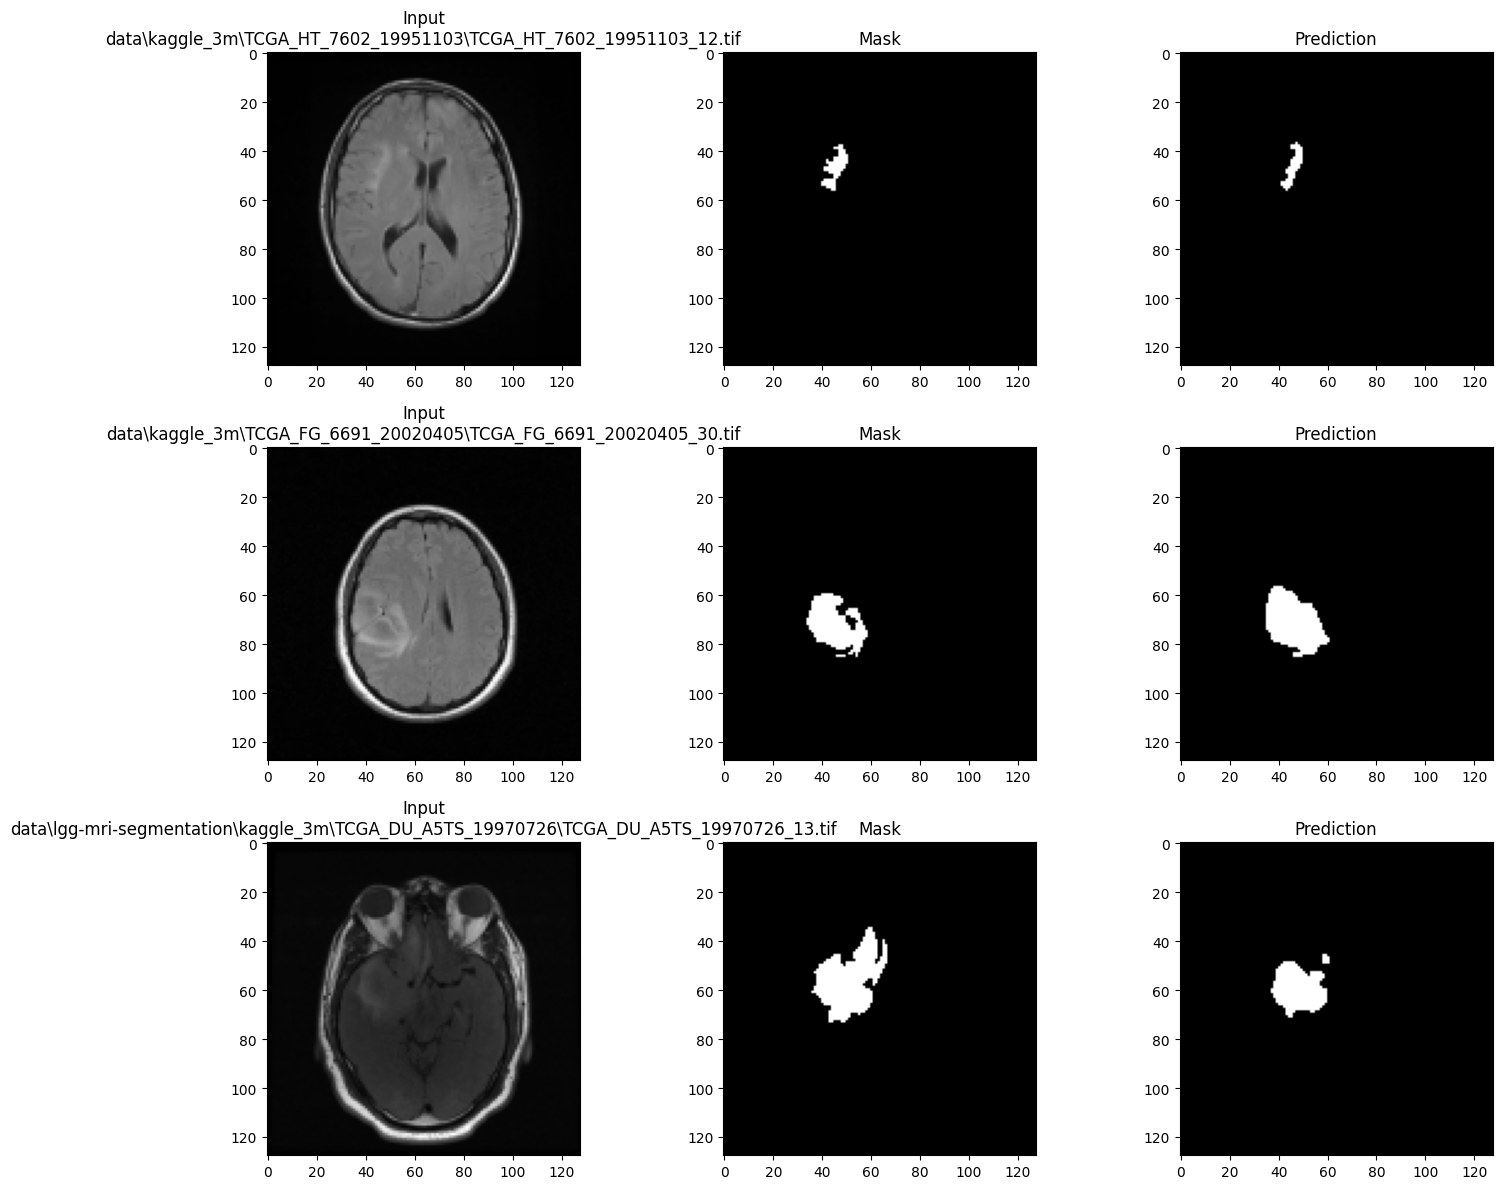

In [20]:
# --- Use the test dataset ---
test_dataset = LGGDataset(test_df, transform=test_transform)

# --- Pick a random batch from test loader ---
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
batch_idx = random.randint(0, len(test_loader) - 1)
imgs, masks, weights = list(test_loader)[batch_idx]
imgs, masks = imgs.to(device), masks.to(device)

# --- Get corresponding file paths for this batch ---
batch_start = batch_idx * test_loader.batch_size
batch_paths = [
    test_dataset.df.iloc[batch_start + i].image_path
    for i in range(len(imgs))
]

# --- Forward pass ---
with torch.no_grad():
    preds = model(imgs)
    preds = (torch.sigmoid(preds) > 0.5).float()  # convert logits to 0/1

# --- Visualization ---
num_to_plot = min(3, len(imgs))
plt.figure(figsize=(14, 4 * num_to_plot))

for i in tqdm(range(num_to_plot), desc="Visualizing predictions"):

    file_path = batch_paths[i]

    # Input
    plt.subplot(num_to_plot, 3, i*3 + 1)
    plt.imshow(imgs[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Input\n{file_path}")

    # Mask
    plt.subplot(num_to_plot, 3, i*3 + 2)
    plt.imshow(masks[i].detach().cpu().squeeze(), cmap='gray')
    plt.title("Mask")

    # Prediction
    plt.subplot(num_to_plot, 3, i*3 + 3)
    plt.imshow(preds[i].detach().cpu().squeeze(), cmap='gray')
    plt.title("Prediction")

plt.tight_layout()
plt.show()
